In [1]:
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.applications import ResNet50, DenseNet201
from tensorflow.keras.applications import resnet, densenet
from keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [2]:
train_path = "/kaggle/input/net-data-isha/Data/train"
valid_path = "/kaggle/input/net-data-isha/Data/valid"
test_path = "/kaggle/input/net-data-isha/Data/test"


In [3]:
from keras.preprocessing.image import ImageDataGenerator

# define the data generators for train and validation sets
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
image_shape = (460,460,3)
N_CLASSES = 5
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')


valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 913 images belonging to 5 classes.
Found 173 images belonging to 5 classes.
Found 713 images belonging to 5 classes.


['adenocarcinoma', 'covid19', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


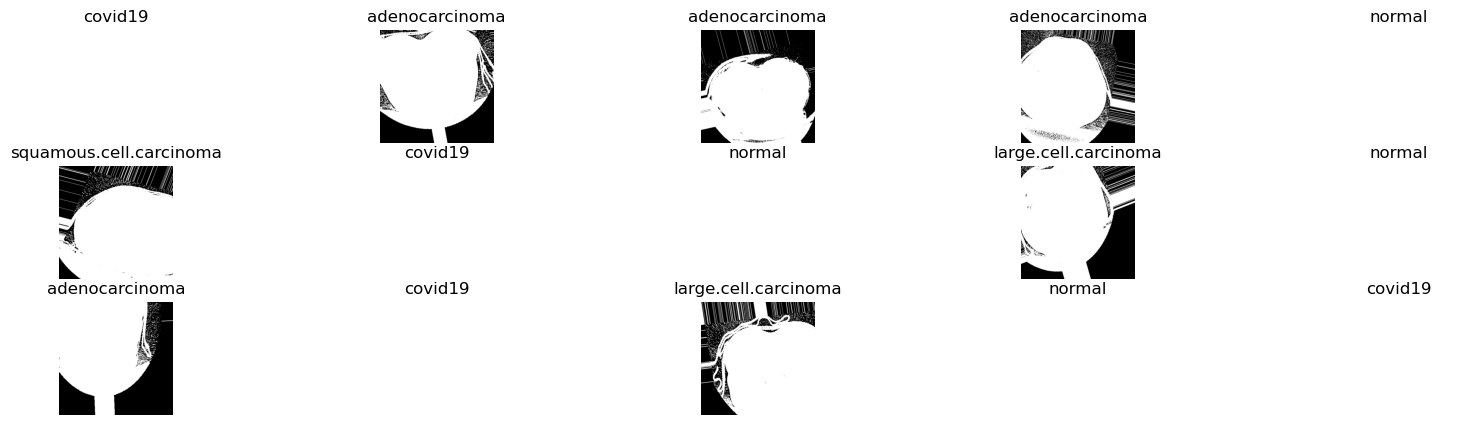

In [5]:
class_names=list(test_generator.class_indices.keys())
print(class_names)

fig = plt.figure(figsize=(20,5))

image_batch,label_batch = test_generator[1]
for i in range(15):
    ax = fig.add_subplot(3,5,i+1,xticks = [], yticks = [])
    ax.imshow(image_batch[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label_batch[i])])


In [6]:
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))

# make all layers except conv5 layers not trainable
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [7]:
# Add the classification layers
x = Flatten()(res_model.output)
x = Dense(N_CLASSES, activation='softmax')(x)

# Create a new model with the VGG16 base and the new top layers
resnet_model = Model(inputs=res_model.input, outputs=x)


# Print the model summary
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 460, 460, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 466, 466, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 230, 230, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [8]:
optimizer = optimizers.Adam(learning_rate= 0.00001)
resnet_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [9]:
checkpointer = ModelCheckpoint(filepath='./finalmodel-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=20)

In [10]:
history_res = resnet_model.fit(train_generator,
                            steps_per_epoch =20,
                            epochs = 56,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])

Epoch 1/56
20/20 [==============================] - ETA: 0s - loss: 1.5293 - acc: 0.3664
Epoch 1: val_loss improved from inf to 1.28137, saving model to ./finalmodel-ResNet50.hdf5
20/20 [==============================] - 83s 3s/step - loss: 1.5293 - acc: 0.3664 - val_loss: 1.2814 - val_acc: 0.5087
Epoch 2/56
20/20 [==============================] - ETA: 0s - loss: 1.0158 - acc: 0.5840
Epoch 2: val_loss improved from 1.28137 to 0.93321, saving model to ./finalmodel-ResNet50.hdf5
20/20 [==============================] - 55s 3s/step - loss: 1.0158 - acc: 0.5840 - val_loss: 0.9332 - val_acc: 0.7168
Epoch 3/56
20/20 [==============================] - ETA: 0s - loss: 0.7734 - acc: 0.7424
Epoch 3: val_loss improved from 0.93321 to 0.77149, saving model to ./finalmodel-ResNet50.hdf5
20/20 [==============================] - 54s 3s/step - loss: 0.7734 - acc: 0.7424 - val_loss: 0.7715 - val_acc: 0.7746
Epoch 4/56
20/20 [==============================] - ETA: 0s - loss: 0.6522 - acc: 0.7719
Epoch 

In [12]:
# Save the model
resnet_model.save('finalmodel-ResNet50.hdf5')

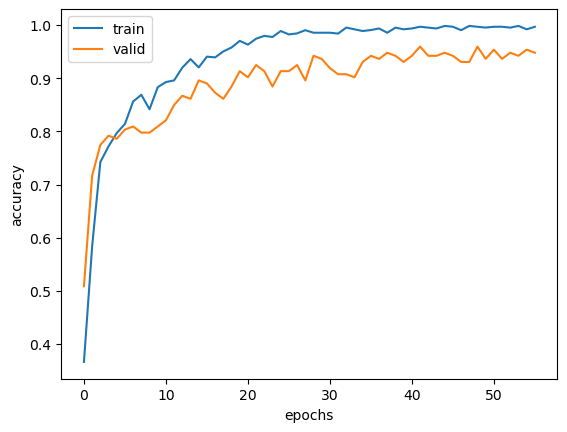

In [13]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

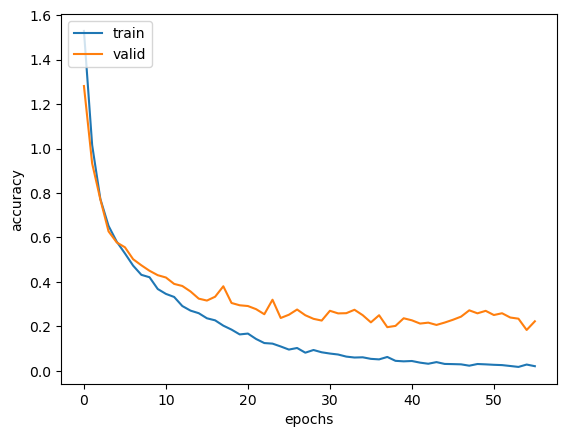

In [14]:
plt.plot(history_res.history['loss'], label = 'train',)
plt.plot(history_res.history['val_loss'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [15]:
result = resnet_model.evaluate(test_generator)

23/23 [==============================] - 49s 2s/step - loss: 0.2124 - acc: 0.9285


In [ ]:
result = resnet_model.evaluate(train_generator)


29/29 [==============================] - 57s 2s/step - loss: 0.0171 - acc: 0.9978


In [16]:
result = resnet_model.evaluate(valid_generator)


6/6 [==============================] - 10s 1s/step - loss: 0.2373 - acc: 0.9422


In [17]:
import tensorflow as tf
from tensorflow import keras

resnet50_model = keras.models.load_model('finalmodel-ResNet50.hdf5')


In [ ]:
import tensorflow as tf
import numpy as np

#model.save('finalmodel-ResNet50.hdf5')




In [ ]:
import tensorflow as tf
import numpy as np

img_path = "/kaggle/input/net-data-isha/Data/test/large.cell.carcinoma/000143.png"
class_names = list(test_generator.class_indices.keys())


# Load the pre-trained ResNet50 model
resnet50_model = keras.models.load_model('finalmodel-ResNet50.hdf5')

# Preprocess the image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
img_array = tf.expand_dims(img_array, 0)



In [ ]:
import tensorflow as tf
import numpy as np

img_path = "/kaggle/input/net-data-isha/Data/test/large.cell.carcinoma/000120.png"
class_names = list(test_generator.class_indices.keys())

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(460, 460))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = resnet50_model.predict(img_array)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(prediction)], 100 * np.max(prediction))
)


In [18]:
paths = ["/kaggle/input/net-data-isha/Data/test/adenocarcinoma/","/kaggle/input/net-data-isha/Data/test/covid19/","/kaggle/input/net-data-isha/Data/test/large.cell.carcinoma/", "/kaggle/input/net-data-isha/Data/test/normal/", "/kaggle/input/net-data-isha/Data/test/squamous.cell.carcinoma/"]
results = {"adeno":{0:0, 1:0, 2:0, 3:0,4:0},
           "covid19":{0:0, 1:0, 2:0, 3:0,4:0},
            "large":{0:0, 1:0, 2:0, 3:0,4:0},
            "normal":{0:0, 1:0, 2:0, 3:0,4:0},
            "squamous":{0:0, 1:0, 2:0, 3:0,4:0}}

for path, key in zip(paths, results.keys()):
    
    for file in os.listdir(path):
        img = tf.keras.utils.load_img(
            (path + file), target_size=(460, 460)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        prediction = resnet50_model.predict(img_array, verbose=0)
        results[key][np.argmax(prediction)] = results.get(key).get(np.argmax(prediction),0) + 1

results

{'adeno': {0: 110, 1: 0, 2: 5, 3: 0, 4: 5},
 'covid19': {0: 0, 1: 194, 2: 0, 3: 6, 4: 0},
 'large': {0: 2, 1: 0, 2: 49, 3: 0, 4: 0},
 'normal': {0: 4, 1: 6, 2: 1, 3: 241, 4: 0},
 'squamous': {0: 1, 1: 0, 2: 0, 3: 0, 4: 89}}

In [19]:
df = pd.DataFrame(results)

print("Overall accuracy is : {:.2f}%\n".format((df["adeno"][0] +df["covid19"][1]+df["large"][2] + df["normal"][3] + df["squamous"][4]) / 714 * 100))

print("Adeno cancer detection accuracy is : {:.2f}%".format(df["adeno"][0] / df["adeno"].sum() * 100))
print("covid19 cancer detection accuracy is : {:.2f}%".format(df["covid19"][1] / df["covid19"].sum() * 100))
print("Large cell cancer detection accuracy is : {:.2f}%".format(df["large"][2] / df["large"].sum() * 100))
print("Normal chest detection accuracy is : {:.2f}%".format(df["normal"][3] / df["normal"].sum() * 100))
print("Squamous cell cancer detection accuracy is : {:.2f}%".format(df["squamous"][4] / df["squamous"].sum() * 100))

print("\nConfusion Matrix :")
df.transpose()

Overall accuracy is : 95.66%

Adeno cancer detection accuracy is : 91.67%
covid19 cancer detection accuracy is : 97.00%
Large cell cancer detection accuracy is : 96.08%
Normal chest detection accuracy is : 95.63%
Squamous cell cancer detection accuracy is : 98.89%

Confusion Matrix :


,0,1,2,3,4
adeno,110,0,5,0,5
covid19,0,194,0,6,0
large,2,0,49,0,0
normal,4,6,1,241,0
squamous,1,0,0,0,89
